### Bag of Words Model for the OHSUmed corpus
#### Establishing a baseline in Keras

The OHSUmed test collection is a subset of the MEDLINE database, which is a bibliographic database of important, peer-reviewed medical literature maintained by the National Library of Medicine. The subset we consider is the collection consisting of the first 20,000 documents from the 50,216 medical abstracts of the year 1991. The classification scheme consists of the 23 Medical Subject Headings (MeSH) categories of cardiovascular diseases group. 

After selecting such category subset, the document number is 13,924 documents (6,285 for training and 7,649 for testing). Of the 23 categories of the cardiovascular diseases group

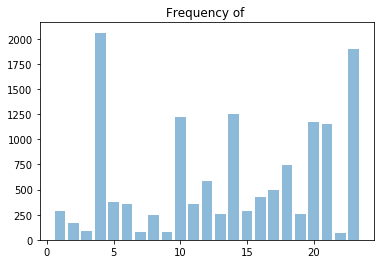

In [102]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%reload_ext autoreload

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

data = pd.read_csv("../data/processed/ohsumed_abstracts.csv", index_col ="Unnamed: 0")

train_posts = data.loc[data.split == 'train', 'doc']
train_tags = data.loc[data.split == 'train', 'label']
test_posts = data.loc[data.split == 'test', 'doc']
test_tags = data.loc[data.split == 'test', 'label']

plot_label_frequency(df, 'label')

## Preprocessing with Keras
### Text Input
Keras has some built in methods for preprocessing text to make preprocessing simple. 

##### Tokenizer class
The Tokenizer class provides methods to count the unique words in our vocabulary and assign each of those words to indices. We’ll create an instance of the Tokenizer class, and then pass it the Pandas dataframe of text we want to train on. Although the Tokenizer function, takes a 'num_words' argument to limit the text to a certain vocabulary size (say, 10,000), we will instead use all words. Note that stopwords were already removed.

##### fit_on_texts
Calling fit_on_texts() automatically creates a word index lookup of our vocabulary, thereby associating each word with a unique number.  

##### texts_to_matrix
With our Tokenizer, we can now use the texts_to_matrix method to create the training data we’ll pass our model. This will take each post’s text and turn it into a vocab_size “bag” array, with 1s indicating the indices where words in a question are present in the vocabulary. 

In [103]:
vocab_size = 10000

tokenize = text.Tokenizer(num_words = vocab_size)
tokenize.fit_on_texts(train_posts)
x_train = tokenize.texts_to_matrix(train_posts)

### Preprocessing output labels
The tag for each question is a number (i.e. “1” or “2”). Instead of using a single int as the label for each input, we’ll turn it into a one-hot vector. **We feed a one-hot vector to our model instead of a single integer because the models will output a vector of probabilities for each document** 

scikit-learn has a **LabelBinarizer class** which makes it easy to build these one-hot vectors. We can pass it the labels column from our Pandas DataFrame and then call fit() and transform() on it:

In [153]:
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

# assign number of classes; useful for building model architecture
num_classes = len(y_test[0])

## Building the Model: Sequential Model API
### One-hot vectors into a 512-dimensional dense layer

To define the layers of our model we’ll use the Keras **Sequential model API**. This lets us easily define the shape of our input data and the type of layers that make up our model. We can start defining our model object using the Sequential() function. The Sequential model is a linear stack of layers.

The input layer will take the vocab_size arrays for each comment. We’ll specify this as a Dense layer in Keras, which means each neuron in this layer will be fully connected to all neurons in the next layer. We pass the Dense layer two parameters: the dimensionality of the layer’s output (number of neurons) and the shape of our input data. Choosing the number of dimensions requires some experimentation, and there is a lot of discussion on the best approach for doing this. It’s common to use a power of 2 as the number of dimensions, so we’ll start with 512

In [154]:
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))

### Generating an output with the softmax activation function 
The model will take the “bag of words” for each comment and output a 20-element array indicating the probability that the question belongs to each of our 20 tags. To achieve this output the layer will use the Softmax activation function. If that sounds confusing, Softmax just means the model will normalize the evidence for each possible label into a probability (from 0 to 1), and these 20 values for a given comment will sum up to 1.

How will our model take the vocab_size input, transform it to a 512-dimensional layer, and transform that into an output layer with 20 probability neurons? The beauty of Keras is that it’ll handle those computations for us — all we need to do is tell it the shape of our input data, output data, and the type of each layer. The following code will complete our model:

In [157]:
model.add(Dense(units=num_classes, activation='sigmoid'))

## Training the Model
### Assigning a Cost Function and Optimizer
To prepare our model for training, we need to call the compile method with the loss function we want to use, the type of optimizer, and the metrics our model should evaluate during training and testing. We’ll use the cross entropy loss function, since each of our abstrats can only belong to one post. The optimizer is the function our model uses to minimize loss. In this example we’ll use the Adam optimizer. There are many optimizers available, all of which are different implementations of gradient descent. For metrics we’ll evaluate accuracy, which will tell us the percentage of abstracts assigned the correct label.

In [158]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['binary_accuracy'])

To train our model, we’ll call the fit() method, pass it our training data and labels, the number of examples to process in each batch (batch size), how many times the model should train on our entire dataset (epochs), and the validation split. validation_split tells Keras what percentage of our training data to reserve for validation.

#### Try tweaking these hyperparameters when using this model on our own data

In [159]:
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=2, 
                    verbose=1,
                    validation_split=0.1)

Train on 5656 samples, validate on 629 samples
Epoch 1/2
5656/5656 [==============================] - 9s 2ms/step - loss: 2.8825 - binary_accuracy: 0.6971 - val_loss: 3.1261 - val_binary_accuracy: 0.7577
Epoch 2/2
5656/5656 [==============================] - 8s 1ms/step - loss: 2.6084 - binary_accuracy: 0.8067 - val_loss: 2.9952 - val_binary_accuracy: 0.8069


In [145]:
len(y_train[[0]])

1